In [18]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
# import scienceplots
# plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define number of particles and get random positions (between 0 and 1) for each particle

In [19]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)

In [20]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)
# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

Give IDs to each particle (this will come in handy later)

In [21]:
ids = torch.arange(n_particles)

Plot initial configuration of particles

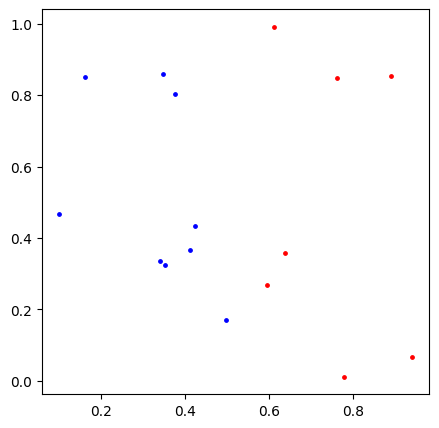

In [22]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=6)

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.

* **Note**: We're using the assumption that particles in a gas move at approximately 500m/s, thanks google.

In [23]:
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

To run this simulation, we need to determine when two particles collide, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

* To determine if two particles collide, we need to find the distance between **all pairs** of particles. If the distance is less than 2 times the radius of each particle, they collide. If there are $n$ particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [24]:
ids_pairs = torch.combinations(ids,2).to(device)
#ids_pairs

We can obtain distances between particles in a similar fashion

* First get the pairs of x-positions of all particles (**NOTE: THIS HAS BEEN UPDATED SINCE THE YOUTUBE VIDEO AND IS MUCH MORE EFFICIENT. THANK YOU TO @swni ON REDDIT FOR THE SUGGESTION**)

In [25]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
x_pairs

tensor([[0.3418, 0.3525],
        [0.3418, 0.9399],
        [0.3418, 0.4236],
        [0.3418, 0.7624],
        [0.3418, 0.4992],
        [0.3418, 0.3475],
        [0.3418, 0.1621],
        [0.3418, 0.8914],
        [0.3418, 0.3771],
        [0.3418, 0.6128],
        [0.3418, 0.7792],
        [0.3418, 0.1014],
        [0.3418, 0.4121],
        [0.3418, 0.5957],
        [0.3418, 0.6381],
        [0.3525, 0.9399],
        [0.3525, 0.4236],
        [0.3525, 0.7624],
        [0.3525, 0.4992],
        [0.3525, 0.3475],
        [0.3525, 0.1621],
        [0.3525, 0.8914],
        [0.3525, 0.3771],
        [0.3525, 0.6128],
        [0.3525, 0.7792],
        [0.3525, 0.1014],
        [0.3525, 0.4121],
        [0.3525, 0.5957],
        [0.3525, 0.6381],
        [0.9399, 0.4236],
        [0.9399, 0.7624],
        [0.9399, 0.4992],
        [0.9399, 0.3475],
        [0.9399, 0.1621],
        [0.9399, 0.8914],
        [0.9399, 0.3771],
        [0.9399, 0.6128],
        [0.9399, 0.7792],
        [0.9

* Then take the difference to get $\Delta x_{ij}$ of all pairs

In [26]:
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dx_pairs

tensor([ 0.0107,  0.5982,  0.0819,  0.4206,  0.1575,  0.0057, -0.1797,  0.5497,
         0.0354,  0.2711,  0.4374, -0.2404,  0.0704,  0.2540,  0.2963,  0.5874,
         0.0711,  0.4099,  0.1467, -0.0050, -0.1904,  0.5389,  0.0246,  0.2603,
         0.4267, -0.2511,  0.0596,  0.2432,  0.2856, -0.5163, -0.1776, -0.4407,
        -0.5925, -0.7778, -0.0485, -0.5628, -0.3271, -0.1608, -0.8386, -0.5278,
        -0.3442, -0.3019,  0.3387,  0.0756, -0.0762, -0.2615,  0.4678, -0.0465,
         0.1892,  0.3555, -0.3223, -0.0115,  0.1721,  0.2144, -0.2631, -0.4149,
        -0.6003,  0.1291, -0.3852, -0.1495,  0.0168, -0.6610, -0.3502, -0.1666,
        -0.1243, -0.1518, -0.3371,  0.3922, -0.1221,  0.1136,  0.2799, -0.3979,
        -0.0871,  0.0965,  0.1388, -0.1854,  0.5440,  0.0297,  0.2654,  0.4317,
        -0.2461,  0.0647,  0.2482,  0.2906,  0.7293,  0.2150,  0.4507,  0.6171,
        -0.0607,  0.2500,  0.4336,  0.4759, -0.5143, -0.2786, -0.1123, -0.7901,
        -0.4793, -0.2957, -0.2534,  0.23

The total distance is just $d_{ij}= \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}$. Since there are $n(n-1)/2$ pairs, there will be $n(n-1)/2$ different values of $d_{ij}$.

In [27]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
y_pairs = torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)
d_pairs

tensor([0.0156, 0.6553, 0.1274, 0.6638, 0.2286, 0.5245, 0.5475, 0.7558, 0.4702,
        0.7103, 0.5444, 0.2747, 0.0770, 0.2625, 0.2971, 0.6409, 0.1301, 0.6659,
        0.2129, 0.5358, 0.5618, 0.7559, 0.4808, 0.7168, 0.5291, 0.2896, 0.0733,
        0.2494, 0.2876, 0.6324, 0.8010, 0.4524, 0.9891, 1.1050, 0.7878, 0.9269,
        0.9803, 0.1704, 0.9293, 0.6066, 0.3987, 0.4187, 0.5364, 0.2739, 0.4336,
        0.4944, 0.6294, 0.3742, 0.5901, 0.5516, 0.3242, 0.0673, 0.2378, 0.2272,
        0.7283, 0.4150, 0.6003, 0.1292, 0.3878, 0.2069, 0.8378, 0.7627, 0.5960,
        0.6035, 0.5064, 0.7066, 0.7615, 0.7887, 0.6462, 0.8300, 0.3217, 0.4975,
        0.2153, 0.1383, 0.2339, 0.1855, 0.5440, 0.0630, 0.2964, 0.9521, 0.4624,
        0.4974, 0.6410, 0.5799, 0.7293, 0.2204, 0.4718, 1.0434, 0.3890, 0.5465,
        0.7271, 0.6864, 0.5167, 0.3108, 0.8503, 0.8792, 0.6836, 0.6557, 0.5571,
        0.3013, 0.8891, 0.4346, 0.4390, 0.5783, 0.5170, 0.9947, 0.7320, 0.6567,
        0.7233, 0.6345, 0.8175, 0.5109, 

# Part 2: Velocities of a Collision

So at each iteration of the simulation, we will evaluate `d_pairs`, and if any of the distances between particles is less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres? In an elastic collision (conservation of energy + momentum + angular momentum), one can show

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [28]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

tensor([[ 0,  1],
        [ 0, 13],
        [ 1, 13],
        [ 3, 13],
        [ 6,  9],
        [14, 15]])

We will call all the particles in the left column "1" and the right column "2"

In [29]:
v1 = v[:,ids_pairs_collide[:,0]]
v2 = v[:,ids_pairs_collide[:,1]]
r1 = r[:,ids_pairs_collide[:,0]]
r2 = r[:,ids_pairs_collide[:,1]]

Then we can compute the new velocity:

In [30]:
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

# Part 3: Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier.

In [38]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, id_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

Set the radius and find the position of all particles as a function of time (3D array `rs` where each axis is $(t,x,y)$).

In [41]:
n_particles = 4

In [39]:
radius = 0.03
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Plot red and blue circles, making sure each is the correct size.

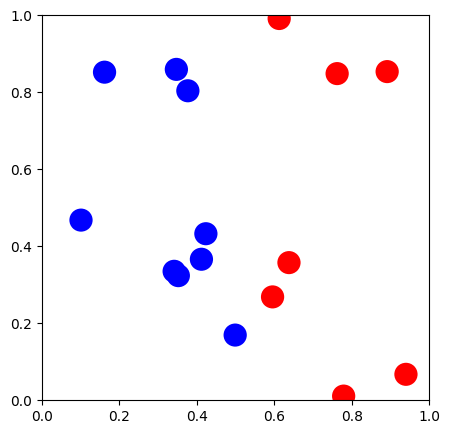

In [33]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl],rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Make initial animation of the simulation

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

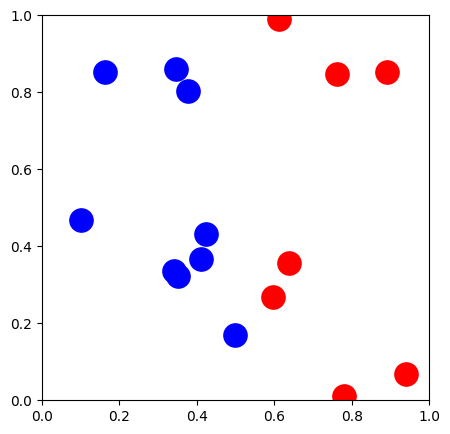

In [35]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = ax.plot([], [], 'o', color='red', markersize=markersize)
blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani3.mp4',writer=writer,dpi=100)

Now that we're sure that it works, lets make a simulation containing many more particles

In [ ]:
n_particles = 5000
r = torch.rand((2,n_particles)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(n_particles)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0005
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Let's look at the final velocity distribution of the particles and compare it to Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

In [ ]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2 / 2)

Plot the final histogram next to this curve:

Text(0, 0.5, '# Particles')

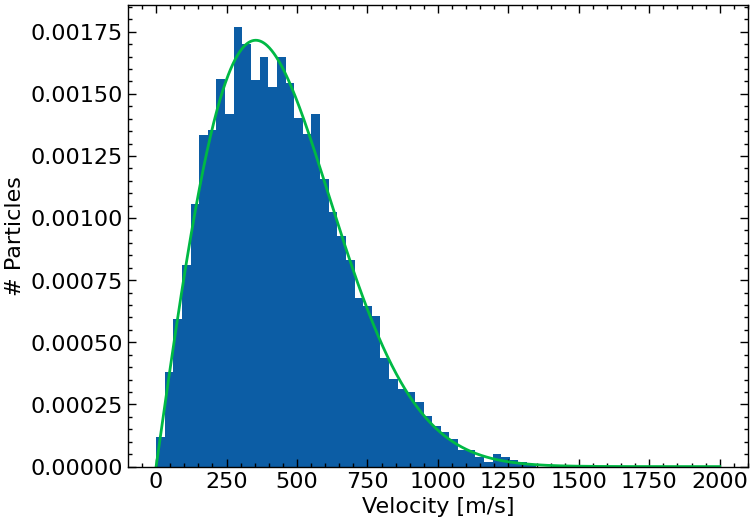

In [ ]:
bins = np.linspace(0,1500,50)
plt.figure()
plt.hist(torch.sqrt(torch.sum(vs[-1]**2, axis=0)).cpu(), bins=bins, density=True)
plt.plot(v,fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')

Finally, we can make an animation of the particles moving around and the histogram at the same time

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].clear()
vmin = 0
vmax = 1
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
markersize = 2 * radius * axes[0].get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = axes[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = axes[0].plot([], [], 'o', color='blue', markersize=markersize)
n, bins, patches = axes[1].hist(torch.sqrt(torch.sum(vs[0]**2, axis=0)).cpu(), bins=bins, density=True)
axes[1].plot(v,fv)
axes[1].set_ylim(top=0.003)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    hist, _ = np.histogram(torch.sqrt(torch.sum(vs[i]**2, axis=0)).cpu(), bins=bins, density=True)
    for i, patch in enumerate(patches):
        patch.set_height(hist[i])
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani_gpu_10000.mp4',writer=writer,dpi=100)